In [15]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import keras_tuner as kt
import plotly.express as px
import numpy as np
import tensorflow as tf
import plotly.graph_objects as go
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import save_model, model_from_json, Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
from keras.models import load_model
# from plotly.subplots import make_subplots
from keras_tuner.engine.hyperparameters import HyperParameters
from typing import Union
import warnings
warnings.simplefilter("ignore", UserWarning)

In [16]:
df = pd.read_csv('../data/cleaned_data.csv')
data = df['close'].values
data = data.reshape(-1,1)

In [17]:
def min_max_scale(train: np.array, val:np.array, test: np.array) -> Union[MinMaxScaler, np.array, np.array, np.array]:
    """ Tranform the train and test data into min max scale of train data"""
    scaler = MinMaxScaler()
    scaler = scaler.fit(train)
    train_normalized = scaler.transform(train)
    test_normalized = scaler.transform(test)
    val_normalized = scaler.transform(val)
    return scaler, train_normalized, val_normalized, test_normalized

def data_divider(data: np.array, threshold: int):
    """ This functions divideds the data (close price) into 80 20 ration for test and train data """
    train_test_divider = int(len(data)*threshold)
    training_data, testing_data = data[:train_test_divider], data[train_test_divider:]
    return training_data, testing_data

def sliding_window(data: [], window_length: int) -> Union[np.array, np.array]:
    """ 
    This function creates a sliding window pattern from the data given and window length given.
    For example:
    Data = [[1],[2],[3],[4],[5],[6]]
    sliding window = 2
    X = [[[1],[2]],[[2],[3]],[[3],[4]],[[4],[5]]]
    Y = [[3],[4],[5],[6]]
    
    """
    X = []
    Y = []
    for i in range(len(data) - window_length):
        X.append(data[i: i+ window_length])
        Y.append(data[i+window_length])
    
    return np.array(X), np.array(Y)

def model_builder(hp):
    """ Keras hyper paramter tuner model builder"""
#     np.random.seed(1234)
#     tf.random.set_seed(1234) 
    hp_activation = hp.Choice('activationfunc', ['relu', 'tanh', 'selu'])
    hp_dropout = hp.Choice('dropout', values=[0.05, 0.1, 0.2])  
    model = Sequential()
    model.add(LSTM(hp.Int('first_layer_neurons', min_value=10, max_value=25, step=2), 
                   activation= hp_activation, return_sequences=True))
    model.add(Dropout(hp_dropout))
    model.add(LSTM(hp.Int('second_layer_neurons', min_value=10, max_value=25, step=2), activation= hp_activation))
    model.add(Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse',
                  metrics='mse')

    return model

def show_best_hyperparamters(best_hps):
    print('Best Hyper Parameters\n')
    print('Layer 1 neuron: ', best_hps.get('first_layer_neurons'))
    print('Layer 2 neuron: ' , best_hps.get('second_layer_neurons'))
    print('Activation Function: ', best_hps.get('activationfunc'))
    print('learning_rate: ', best_hps.get('learning_rate'))
    print('Dropout rate: ', best_hps.get('dropout'))
    
def calculate_metrics(test: np.ndarray, predict: np.ndarray) -> float:
    """."""
    print(f'RMSE: {mean_squared_error(test.flatten(), predict.flatten(), squared=False)}')
    print(f'MSE: {mean_squared_error(test.flatten(), predict.flatten())}')
    print(f'MAE: {mean_absolute_error(test.flatten(), predict.flatten())}')

In [18]:
lookback = 100
train, test = data_divider(data, 0.8)
val, test = data_divider(test, 0.5)
scaler, train_normalized, val_normalized, test_normalized = min_max_scale(train, val, test)
x_train, y_train = sliding_window(train_normalized, lookback)
x_val, y_val = sliding_window(val_normalized, lookback)
x_test, y_test = sliding_window(test_normalized, lookback)

In [19]:
tuner = kt.RandomSearch(model_builder, objective='val_mse', max_trials=20, directory='my_dir', project_name='intro_to_kt')
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [20]:
def model():
    
#     np.random.seed(1234)
#     tf.random.set_seed(1234)
    
    model = keras.Sequential()
    model.add(LSTM(24, activation= 'tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(24, activation= 'tanh'))
    model.add(Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                  loss='mse',
                  metrics='mse')

    return model

In [21]:
best_hps = tuner.get_best_hyperparameters()[0]
show_best_hyperparamters(best_hps)

Best Hyper Parameters

Layer 1 neuron:  24
Layer 2 neuron:  24
Activation Function:  selu
learning_rate:  0.001
Dropout rate:  0.2


In [22]:
# Build the model with the best hp.
# model = model_builder(best_hps)
model = model()

# stop_training_early = keras.callbacks.EarlyStopping()
stop_training_early = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 2)
history = model.fit(x_train, y_train, epochs=60 , verbose=1, shuffle=False, validation_data = (x_val, y_val), callbacks=[stop_training_early])

Epoch 1/60
1029/1029 [==============================] - 58s 52ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 2/60
1029/1029 [==============================] - 47s 45ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 3/60
1029/1029 [==============================] - 50s 49ms/step - loss: 5.4616e-04 - mse: 5.4616e-04 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 4/60
1029/1029 [==============================] - 50s 48ms/step - loss: 3.9183e-04 - mse: 3.9183e-04 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 5/60
1029/1029 [==============================] - 48s 47ms/step - loss: 3.6390e-04 - mse: 3.6390e-04 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 6/60
1029/1029 [==============================] - 47s 46ms/step - loss: 3.5007e-04 - mse: 3.5007e-04 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 7/60
1029/1029 [==============================] - 46s 45ms/step - loss: 3.1626e-04 - mse: 3.1626e-04 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 8/

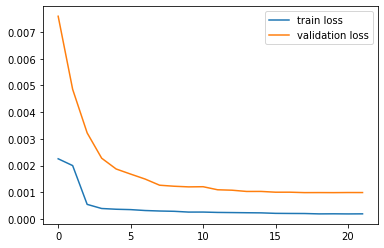

In [23]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

In [28]:
# model = load_model('saved_model/hourly_model')
# model.save('saved_model/hourly_100_model')
# model.summary()

INFO:tensorflow:Assets written to: saved_model/hourly_100_model\assets


INFO:tensorflow:Assets written to: saved_model/hourly_100_model\assets


## Prediction

In [25]:
y_predict = model.predict(x_test)

126/126 [==============================] - 2s 13ms/step


In [26]:
# plt.plot(y_test.flatten(), label='test')
# plt.plot(y_predict.flatten(), 'r-', label='predict')
# plt.legend()
fig = go.Figure()
fig.add_trace(go.Scatter(y = y_test.flatten(), name = 'Actual'))
fig.add_trace(go.Scatter(y = y_predict.flatten(), name = 'Predict'))

In [27]:
calculate_metrics(y_test, y_predict)

RMSE: 0.025861437610968145
MSE: 0.0006688139553059977
MAE: 0.022858675916026517


In [24]:
calculate_metrics(y_test, y_predict)

MSE: 0.0002667173164588174
MAE: 0.011836310460463857
